# Multiclass Support Vector Machines and Kernels


Please watch
https://www.youtube.com/watch?v=xpHQ6UhMlx4&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=14


https://www.youtube.com/watch?v=FwYNPomeBBg&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=15



https://www.youtube.com/watch?v=FgTQG2IozlM&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=22


https://www.youtube.com/watch?v=erqL3y2es1I&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=23

# RECAP
## SVM Dual Objective with Slack Variable


$$ min_{\alpha_1, \dots, \alpha_n} \frac{1}{2} \sum_i ^n \sum_j ^n \alpha_i \alpha_j y_i y_j K_{ij} - \sum_i ^n \alpha_i \\ \text{subject to } \\
\sum_i ^n \alpha_i y_i = 0 \;: \; \alpha_i \ge 0
$$
$$ w = \sum_i ^n \alpha_i y_i x_i $$
$$ b = y_i - \sum_j ^n \alpha_j y_j x_j^T x_i  \; \text{ for all } \alpha_i > 0$$

## SVM Dual Objective with Slack Variable


$$ min_{\alpha_1, \dots, \alpha_n} \frac{1}{2} \sum_i ^n \sum_j ^n \alpha_i \alpha_j y_i y_j K_{ij} - \sum_i ^n \alpha_i \\ \text{subject to } \\
\sum_i ^n \alpha_i y_i = 0 \;: \; \alpha_i \in [0,C]
$$
$$ w = \sum_i ^n \alpha_i y_i x_i $$
$$ b = y_i - \sum_j ^n \alpha_j y_j x_j^T x_i  \; \text{ for all } \alpha_i > 0$$

Langrangian Karush-Kuhn-Tucker (KKT) Dual Formulation. $K$ stands for __the kernel matrix.__

# Linear Kernel

$$ K_{i,j} = x_i ^t x_j$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
import cvxopt
import cvxopt.solvers
np.random.seed(1)

In [2]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p
def gaussian_kernel(x, y, sigma=.01):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))
def exponential_kernel(a,b,sigma=.2,mu=0):
    x=a-b
    return np.exp(-0.5 * ( 1/(2*np.power(sigma,2)) ) * ( np.power(x-mu,2)))
def laplacian_kernel(a,b,sigma=.2,mu=0):
    x=a-b
    return np.exp(-0.5 * ( 1/(2*np.power(sigma,2)) ) * ( np.abs(x-mu)))

In [3]:
class SVM_QP:
    """ Maximum margin classifier - Support Vector Machines 
    as a quadratic optimization problem
    
    min_{w,b}   ||w||_2 subject to \forall y_i (w^T x_i + b) >= 1
    """
    
    def __init__(self,kernel=linear_kernel,sigma=None,C=None):
        self.C=C
        self.kernel=kernel
        self.sigma=sigma
 
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Dot product between each and every pair of inputs
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.sigma:
                    K[i,j] = self.kernel(X[i], X[j],self.sigma)

        # Solves a quadratic program
        """
        minimize    (1/2)*a'*P*a + q'*a
        subject to  G*a <= h
                    A*a = b.
                    
        P = (\sum_i \sum_j a_i a_j y_i y_j x_i^T x_j) 
        q = -\sum_i x_i
        
        G= \forall i a_i >= 0 (NO SLACK)
        """
        P = cvxopt.matrix(np.outer(y,y) * K)
        # -|a|
        q= cvxopt.matrix(np.ones(n_samples) * -1)
        
        """ (1) Linear Constraint  : Inner product of alpha with labels should be 0 """ 
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            # If there are no slack variables
            """ (2.1) Linear Constraint  : every alpha is positive """ 
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            # If there are slack variables
            """ (2.2) Linear Constraint  : every alpha is between 0 or C""" 
            G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, 
                                     G, h, 
                                     A, b)
        # Lagrange multipliers
        a = np.ravel(solution['x'])
        
        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print ("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
            
        if len(self.a)>0:
            self.b /= len(self.a)
    
        # Weight vector
        self.w = None
            
        return self

    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                if self.sigma:
                    s += a * sv_y * self.kernel(X[i], sv,self.sigma)
                y_predict[i] = s
        return y_predict + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot_decision_boundary(self,X,y,plot_support_vector=False):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], c=y, s=50,cmap='RdBu')
        ax.set_title(f'SVM', size=14)
        
        xx_min,xy_min=X.min(axis=0)
        xx_max,xy_max=X.max(axis=0)

        # Visualization works perfectly
        xlim,ylim = (xx_min-1, xx_max+1), (xy_min-1, xy_max+1)
        xg = np.linspace(xlim[0], xlim[1], 60)
        yg = np.linspace(ylim[0], ylim[1], 40)
        xx, yy = np.meshgrid(xg, yg)
        Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T
        for label, color in enumerate(['red', 'blue']):
            Pm=self.project(Xgrid)
            c=ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,cmap=color.title() + 's')
            ax.contour(xx, yy, Pm.reshape(xx.shape),levels=[-1,0,1],
                       colors=color,linestyles=['--', '-', '--'],alpha=0.2)
        fig.colorbar(c, ax=ax)
        ax.set(xlim=xlim, ylim=ylim)

        if plot_support_vector:
            plt.scatter(self.sv[:, 0],self.sv[:, 1],s=300, linewidth=2, facecolors='g',label='Support Vectors');

            pred=self.project(X)
            for i in range(len(X)):
                if -1.1<pred[i]<1.1:
                    plt.annotate(f'  {pred[i]:.3},{y[i]}',xy=(X[i]))
            plt.legend()
        plt.show()
        return self

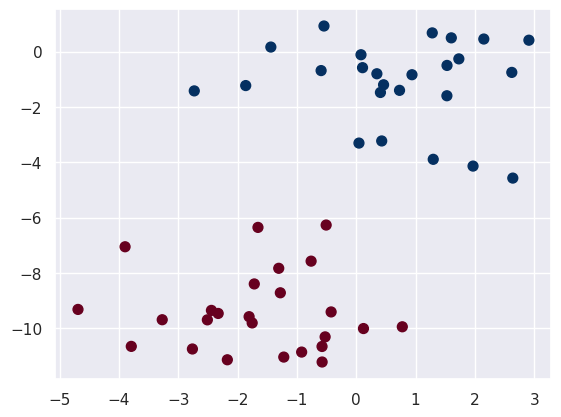

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(50, 2, centers=2, random_state=2, cluster_std=1.4)
y[y==0]=-1.0
y=y.astype(np.float64)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='RdBu')

# SVM RFB $\sigma=1$

     pcost       dcost       gap    pres   dres
 0: -5.8241e+00 -1.7158e+01  1e+01  2e-16  1e+00
 1: -6.2975e+00 -7.4626e+00  1e+00  3e-16  2e-01
 2: -6.5879e+00 -6.8280e+00  2e-01  4e-16  3e-02
 3: -6.6658e+00 -6.6948e+00  3e-02  5e-16  8e-04
 4: -6.6784e+00 -6.6796e+00  1e-03  5e-16  9e-06
 5: -6.6791e+00 -6.6792e+00  2e-04  5e-16  1e-06
 6: -6.6792e+00 -6.6792e+00  2e-06  4e-16  1e-08
Optimal solution found.
29 support vectors out of 50 points


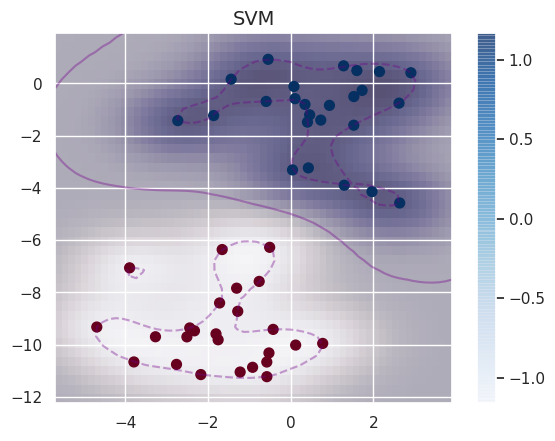

1.0

In [5]:
clr=SVM_QP(kernel=gaussian_kernel,sigma=1.0).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

# SVM RFB $\sigma=.5$

     pcost       dcost       gap    pres   dres
 0: -1.1344e+01 -3.0146e+01  2e+01  7e-16  2e+00
 1: -1.3003e+01 -1.4497e+01  1e+00  5e-16  2e-01
 2: -1.3607e+01 -1.3931e+01  3e-01  1e-15  4e-02
 3: -1.3669e+01 -1.3692e+01  2e-02  9e-16  5e-04
 4: -1.3677e+01 -1.3677e+01  7e-04  1e-15  4e-06
 5: -1.3677e+01 -1.3677e+01  1e-05  9e-16  5e-08
 6: -1.3677e+01 -1.3677e+01  2e-07  9e-16  5e-10
Optimal solution found.
41 support vectors out of 50 points


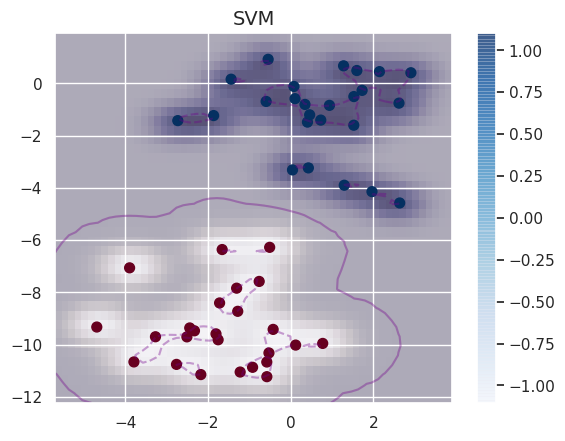

1.0

In [6]:
SVM_QP(kernel=gaussian_kernel,sigma=.5).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

     pcost       dcost       gap    pres   dres
 0: -1.8750e+01 -4.3750e+01  2e+01  3e-16  2e+00
 1: -2.3595e+01 -2.3977e+01  4e-01  8e-16  2e-01
 2: -2.5000e+01 -2.5044e+01  4e-02  0e+00  6e-17
 3: -2.5000e+01 -2.5000e+01  4e-04  0e+00  2e-17
 4: -2.5000e+01 -2.5000e+01  4e-06  2e-15  9e-17
Optimal solution found.
50 support vectors out of 50 points


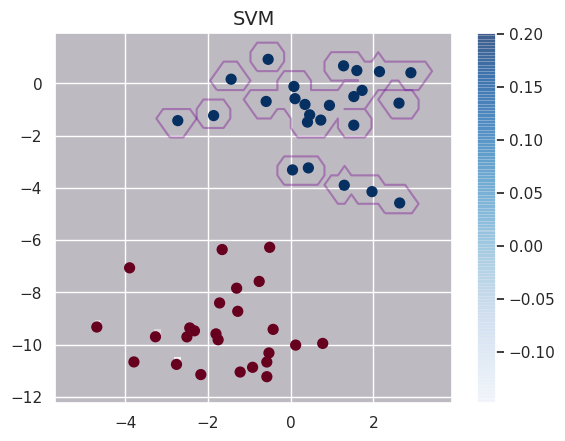

1.0

In [7]:
SVM_QP(kernel=gaussian_kernel,sigma=.01).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

     pcost       dcost       gap    pres   dres
 0: -6.8568e+00 -1.8918e+01  1e+02  8e+00  2e+00
 1: -9.0771e+00 -2.1345e+01  3e+01  2e+00  5e-01
 2: -1.7083e+01 -2.8323e+01  3e+01  1e+00  3e-01
 3: -2.1494e+01 -2.5354e+01  8e+00  4e-01  9e-02
 4: -2.2870e+01 -2.4634e+01  2e+00  3e-02  7e-03
 5: -2.4308e+01 -2.4343e+01  4e-02  2e-04  4e-05
 6: -2.4338e+01 -2.4338e+01  4e-04  2e-06  4e-07
 7: -2.4338e+01 -2.4338e+01  4e-06  2e-08  4e-09
Optimal solution found.
3 support vectors out of 50 points


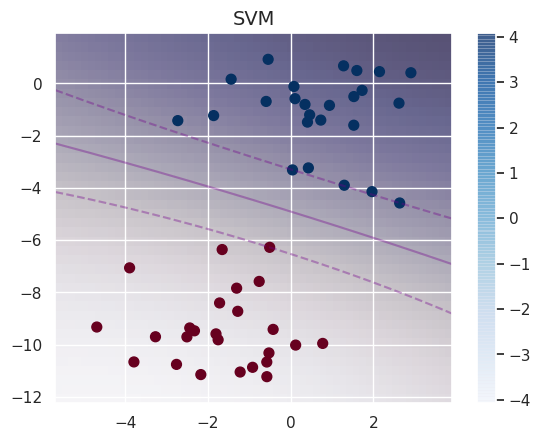

1.0

In [8]:
SVM_QP(kernel=gaussian_kernel,sigma=10).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

In [9]:
def spiral_data_gen(N=100,D=2,K=2):
    """
    N: number of points per class
    D:dimensionality
    K:number of classes
    """
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K) # class labels
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
        # lets visualize the data:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()
    y[y==0]=-1
    return X,y

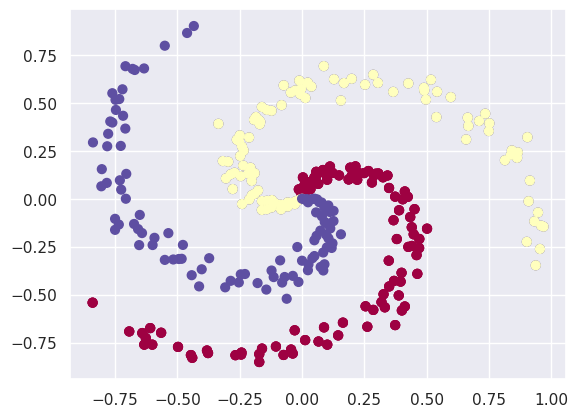

(300, 2) (300,)
float64 float64


In [10]:
X,y=spiral_data_gen(K=3)
print(X.shape, y.shape)
print(X.dtype, y.dtype)

# MULTICLASS SVMs

$$ \mathcal D = {(\mathcal x_i , y_i)}$$
where 
1. $\mathbf{x}_i \in \mathbb R ^d$
2. $y_i \in [1,2,\dots,k]$

$$ \hat y = argmax_{m \in [k]} \mathbf{w}^T _m \mathbf{x},$$
where 
1. $\mathbf{w}_m \in \mathbb R ^d$ a prototype representing the $m^{th}$ class  
2. $\mathbf{w}^T _m \mathbf{x}$ represents the score of the $m^{th}$ class w.r.t. $\mathbf x$.





### Optimization problem
$$ minimize_{\mathbf w_1 , \dots , \mathbf w_k} \frac{1}{2} \sum_m ^k || \mathbf w_m |||^2 + C \sum_i ^n \big[ 1 + max_{m\not=y_i} \mathbf{w}^T _m \mathbf{x}_i - \mathbf{w}^T _{y_i} \mathbf{x}_i \big]_+ $$
where $C>0$ 

1. If the score of the correct class is larger than the scroe of the "closest"class by at least 1, we suffer no loss.



### Dual Formulation



$$ minimize_{\mathbf \alpha} \; f(\mathbf \alpha) = \frac{1}{2} \sum_m ^k || \mathbf w _m (\mathbf \alpha)||^2 + \sum_i ^n \sum_m ^k \Delta_i ^m \alpha_i ^m $$
subject to
1. $ \alpha_i ^m \le C_i ^m \; \forall i \in [n] \; \forall m \in [k]$.
2. $\sum_m ^k \alpha_i ^m = 0 \; \forall i \in [n]$



$C_i ^m = C$ if $m=y_i$, otherwise $C_i^m=0$

$ \Delta_i ^m = 0 $ if $m =y_i$ and 1 otherwise

#### The primal-dual relationship is given by

$$ \mathbf w _m (\mathbf \alpha) = \sum_i ^n \alpha_i ^m \mathbf x_i \; \; \forall m \in [k]$$

# Derivative w.r.t. $\mathbf \alpha$



$$ g_i ^m = \frac{\partial f}{ \partial \alpha_i ^m} = \mathbf w_m (\alpha)^T \mathbf x_i + \Delta_i ^m \; \; \forall i \in [n] \; \forall m \in [k]$$